# Deep reinforcement learning with Pong from pixels

This tutorial demonstrates how to implement a deep reinforcement learning (RL) agent from scratch using a policy gradient method that learns to play the [Pong](https://gym.openai.com/envs/Pong-v0/) video game using screen pixels as inputs with NumPy. Your Pong agent will obtain experience on the go using an [artificial neural network](https://en.wikipedia.org/wiki/Artificial_neural_network) as its [policy](https://en.wikipedia.org/wiki/Reinforcement_learning).

Pong is a 2D game from 1972 where two players use "rackets" to play a form of table tennis. Each player moves the racket up and down the screen and tries to hit a ball in their opponent's direction by touching it. The goal is to hit the ball such that it goes past the opponent's racket (they miss their shot). According to the rules, if a player reaches 21 points, they win. In Pong, the RL agent that learns to play against an opponent is displayed on the right.

![Diagram showing operations detailed in this tutorial](_static/tutorial-deep-reinforcement-learning-with-pong-from-pixels.png)

This example is based on the [code](https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5) developed by [Andrej Karpathy](https://karpathy.ai) for the [Deep RL Bootcamp](https://sites.google.com/view/deep-rl-bootcamp/home) in 2017 at UC Berkeley. His [blog post](http://karpathy.github.io/2016/05/31/rl/) from 2016 also provides more background on the mechanics and theory used in Pong RL.

## Prerequisites

- **OpenAI Gym**: To help with the game environment, you will use [Gym](https://gym.openai.com) — an open-source Python interface [developed by OpenAI](https://arxiv.org/abs/1606.01540) that helps perform RL tasks while supporting many simulation environments.
- **Python and NumPy**: The reader should have some knowledge of Python, NumPy array manipulation, and linear algebra.
- **Deep learning and deep RL**: You should be familiar with main concepts of [deep learning](https://en.wikipedia.org/wiki/Deep_learning), which are explained in the [Deep learning](http://www.cs.toronto.edu/~hinton/absps/NatureDeepReview.pdf) paper published in 2015 by Yann LeCun, Yoshua Bengio, and Geoffrey Hinton, who are regarded as some of the pioneers of the field. The tutorial will try to guide you through the main concepts of deep RL and you will find various literature with links to original sources for your convenience.
- **Jupyter notebook environments**: Because RL experiments can require high computing power, you can run the tutorial on the cloud for free using [Binder](https://mybinder.org) or [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb) (which offers free limited GPU and TPU acceleration).
- **Matplotlib**: For plotting images. Check out the [installation](https://matplotlib.org/3.3.3/users/installing.html) guide to set it up in your environment.

This tutorial can also be run locally in an isolated environment, such as [Virtualenv](https://virtualenv.pypa.io/en/stable/) and [conda](https://docs.conda.io/).

## Table of contents

- A note on RL and deep RL
- Deep RL glossary
1. Set up Pong
2. Preprocess frames (the observation)
3. Create the policy (the neural network) and the forward pass
4. Set up the update step (backpropagation)
5. Define the discounted rewards (expected return) function
6. Train the agent for 3 episodes
7. Next steps
8. Appendix
    - Notes on RL and deep RL
    - How to set up video playback in your Jupyter notebook
---

### A note on RL and deep RL

In [_RL_](https://en.wikipedia.org/wiki/Reinforcement_learning), your agent learns from trial and error by interacting with an environment using a so-called policy to gain experience. After taking one action, the agent receives information about its reward (which it may or may not get) and the next observation of the environment. It can then proceed to take another action. This happens over a number of episodes and/or until the task is deemed to be complete.

The agent's policy works by "mapping" the agent's observations to its actions — that is, assigning a presentation of what the agent observes with required actions. The overall goal is usually to optimize the agent's policy such that it maximizes the expected rewards from each observation.

For detailed information about RL, there is an [introductory book](https://web.archive.org/web/20050806080008/http://www.cs.ualberta.ca/~sutton/book/the-book.html) by Richard Sutton and Andrew Barton.

Check out the Appendix at the end of the tutorial for more information.

### Deep RL glossary

Below is a concise glossary of deep RL terms you may find useful for the remaining part of the tutorial:

- In a finite-horizon world, such as a game of Pong, the learning agent can explore (and exploit) the _environment_ over an _episode_. It usually takes many episodes for the agent to learn.
- The agent interacts with the _environment_ using _actions_.
- After taking an action, the agent receives some feedback through a _reward_ (if there is one), depending on which action it takes and the _state_ it is in. The state contains information about the environment.
- The agent's _observation_ is a partial observation of the state — this is the term this tutorial prefers (instead of _state_).
- The agent can choose an action based on cumulative _rewards_ (also known as the _value function_) and the _policy_. The _cumulative reward function_ estimates the quality of the observations the agent visits using its _policy_.
- The _policy_ (defined by a neural network) outputs action choices (as (log) probabilities) that should maximize the cumulative rewards from the state the agent is in.
- The _expected return from an observation_, conditional to the action, is called the _action-value_ function. To provide more weight to shorter-term rewards versus the longer-term ones, you usually use a _discount factor_ (often a floating point number between 0.9 and 0.99).
- The sequence of actions and states (observations) during each policy "run" by the agent is sometimes referred to as a _trajectory_ — such a sequence yields _rewards_.

You will train your Pong agent through an "on-policy" method using policy gradients — it's an algorithm belonging to a family of _policy-based_ methods. Policy gradient methods typically update the parameters of the policy with respect to the long-term cumulative reward using [_gradient descent_](https://en.wikipedia.org/wiki/Gradient_descent) that is widely used in machine learning. And, since the goal is to maximize the function (the rewards), not minimize it, the process is also called _gradient ascent_. In other words, you use a policy for the agent to take actions and the objective is to maximize the rewards, which you do by computing the gradients and use them to update the parameters in the policy (neural) network.

## Set up Pong

**1.** First, you should install OpenAI Gym (using `pip install gym[atari]` - this package is currently not available on conda), and import NumPy, Gym and the necessary modules:

In [1]:
import numpy as np
import gym

Gym can monitor and save the output using the `Monitor` wrapper:

In [2]:
from gym import wrappers
from gym.wrappers import Monitor

**2.** Instantiate a Gym environment for the game of Pong:

In [3]:
env = gym.make("Pong-v0")

**3.** Let's review which actions are available in the `Pong-v0` environment:

In [4]:
print(env.action_space)

Discrete(6)


In [5]:
print(env.get_action_meanings())

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


There are 6 actions. However, `LEFTFIRE` is actually `LEFT`, `RIGHTFIRE` — `RIGHT`, and `NOOP` — `FIRE`.

For simplicity, your policy network will have one output — a (log) probability for "moving up" (indexed at `2` or `RIGHT`). The other available action will be indexed at 3 ("move down" or `LEFT`).

**4.** Gym can save videos of the agent's learning in an MP4 format — wrap `Monitor()` around the environment by running the following:

In [6]:
env = Monitor(env, "./video", force=True)

While you can perform all kinds of RL experiments in a Jupyter notebook, rendering images or videos of a Gym environment to visualize how your agent plays the game of Pong after training can be rather challenging. If you want to set up video playback in a notebook, you can find the details in the Appendix at the end of this tutorial.

## Preprocess frames (the observation)

In this section you will set up a function to preprocess the input data (game observation) to make it digestible for the neural network, which can only work with inputs that are in a form of tensors (multidimensional arrays) of floating-point type.

Your agent will use the frames from the Pong game — pixels from screen frames — as input-observations for the policy network. The game observation tells the agent about where the ball is before it is fed (with a forward pass) into the neural network (the policy). This is similar to DeepMind's [DQN](https://deepmind.com/research/open-source/dqn) method (which is further discussed in the Appendix).

Pong screen frames are 210x160 pixels over 3 color dimensions (red, green and blue). The arrays are encoded with `uint8` (or 8-bit integers), and these observations are stored on a Gym Box instance.

**1.** Check the Pong's observations:

In [7]:
print(env.observation_space)

Box(0, 255, (210, 160, 3), uint8)


In Gym, the agent's actions and observations can be part of the `Box` (n-dimensional) or `Discrete` (fixed-range integers) classes.

**2.** You can view a random observation — one frame — by:

    1) Setting the random `seed` before initialization (optional).

    2) Calling  Gym's `reset()` to reset the environment, which returns an initial observation.

    3) Using Matplotlib to display the `render`ed observation.

(You can refer to the OpenAI Gym core [API](https://github.com/openai/gym/blob/master/gym/core.py) for more information about Gym's core classes and methods.)

(210, 160, 3)


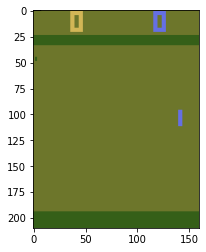

In [8]:
import matplotlib.pyplot as plt

env.seed(42)
env.reset()
random_frame = env.render(mode="rgb_array")
print(random_frame.shape)
plt.imshow(random_frame)

To feed the observations into the policy (neural) network, you need to convert them into 1D grayscale vectors with 6,400 (80x80x1) floating point arrays. (During training, you will use NumPy's [`np.ravel()`](https://numpy.org/doc/stable/reference/generated/numpy.ravel.html) function to flatten these arrays.)

**3.** Set up a helper function for frame (observation) preprocessing:

In [9]:
def frame_preprocessing(observation_frame):
    # Crop the frame.
    observation_frame = observation_frame[35:195]
    # Downsample the frame by a factor of 2.
    observation_frame = observation_frame[::2, ::2, 0]
    # Remove the background and apply other enhancements.
    observation_frame[observation_frame == 144] = 0  # Erase the background (type 1).
    observation_frame[observation_frame == 109] = 0  # Erase the background (type 2).
    observation_frame[observation_frame != 0] = 1  # Set the items (rackets, ball) to 1.
    # Return the preprocessed frame as a 1D floating-point array.
    return observation_frame.astype(float)

**4.** Preprocess the random frame from earlier to test the function — the input for the policy network is an 80x80 1D image:

(80, 80)


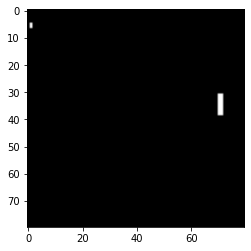

In [10]:
preprocessed_random_frame = frame_preprocessing(random_frame)
plt.imshow(preprocessed_random_frame, cmap="gray")
print(preprocessed_random_frame.shape)

## Create the policy (the neural network) and the forward pass

Next, you will define the policy as a simple feedforward network that uses a game observation as an input and outputs an action log probability:

- For the _input_, it will use the Pong video game frames — the preprocessed 1D vectors with 6,400 (80x80) floating point arrays.
- The _hidden layer_ will compute the weighted sum of inputs using NumPy's dot product function [`np.dot()`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) for the arrays and then apply a _non-linear activation function_, such as [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).
- Then, the _output layer_ will perform the matrix-multiplication again of  weight parameters and the hidden layer's output (with [`np.dot()`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)), and send that information through a [softmax](https://en.wikipedia.org/wiki/Softmax_function) _activation function_.
- In the end, the policy network will output one action log probability (given that observation) for the agent — the probability for Pong action indexed in the environment at 2 ("moving the racket up").

**1.** Let's instantiate certain parameters for the input, hidden, and output layers, and start setting up the network model.

Start by creating a random number generator instance for the experiment
(seeded for reproducibility):

In [11]:
rng = np.random.default_rng(seed=12288743)

Then:

  - Set the input (observation) dimensionality - your preprocessed screen frames:

In [12]:
D = 80 * 80

  - Set the number of hidden layer neurons.

In [13]:
H = 200

  - Instantiate your policy (neural) network model as an empty dictionary.

In [14]:
model = {}

In a neural network, _weights_ are important adjustable parameters that the network fine-tunes by forward and backward propagating the data.

**2.** Using a technique called [Xavier initialization](https://www.deeplearning.ai/ai-notes/initialization/#IV), set up the network model's initial weights with NumPy's [`Generator.standard_normal()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.standard_normal.html) that returns random numbers over a standard Normal distribution, as well as [`np.sqrt()`](https://numpy.org/doc/stable/reference/generated/numpy.sqrt.html?highlight=numpy.sqrt#numpy.sqrt):

In [15]:
model["W1"] = rng.standard_normal(size=(H, D)) / np.sqrt(D)
model["W2"] = rng.standard_normal(size=H) / np.sqrt(H)

**3.** Your policy network starts by randomly initializing the weights and feeds the input data (frames) forward from the input layer through a hidden layer to the output layers. This process is called the _forward pass_ or _forward propagation_, and is outlined in the function `policy_forward()`:

In [16]:
def policy_forward(x, model):
    # Matrix-multiply the weights by the input in the one and only hidden layer.
    h = np.dot(model["W1"], x)
    # Apply non-linearity with ReLU.
    h[h < 0] = 0
    # Calculate the "dot" product in the outer layer.
    # The input for the sigmoid function is called logit.
    logit = np.dot(model["W2"], h)
    # Apply the sigmoid function (non-linear activation).
    p = sigmoid(logit)
    # Return a log probability for the action 2 ("move up")
    # and the hidden "state" that you need for backpropagation.
    return p, h

Note that there are two _activation functions_ for determining non-linear relationships between inputs and outputs. These [non-linear functions](https://en.wikipedia.org/wiki/Activation_function) are applied to the output of the layers:

- [Rectified linear unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)): defined as `h[h<0] = 0` above. It returns 0 for negative inputs and the same value if it's positive.
- [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function): defined below as `sigmoid()`. It "wraps" the last layer's output and returns an action log probability in the (0, 1) range.

**4.** Define the sigmoid function separately with NumPy's [`np.exp()`](https://numpy.org/doc/stable/reference/generated/numpy.exp.html?highlight=numpy.exp#numpy.exp) for computing exponentials:

In [17]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

## Set up the update step (backpropagation)

During learning in your deep RL algorithm, you use the action log probabilities (given an observation) and the discounted returns (for example, +1 or -1 in Pong) and perform the _backward pass_ or _backpropagation_ to update the parameters — the policy network's weights.

**1.** Let's define the backward pass function (`policy_backward()`) with the help of NumPy's modules for array multiplication — [`np.dot()`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html?highlight=numpy.dot#numpy.dot) (matrix multiplication), [`np.outer()`](https://numpy.org/doc/stable/reference/generated/numpy.outer.html) (outer product computation), and [`np.ravel()`](https://numpy.org/doc/stable/reference/generated/numpy.ravel.html) (to flatten arrays into 1D arrays):

In [18]:
def policy_backward(eph, epdlogp, model):
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model["W2"])
    dh[eph <= 0] = 0
    dW1 = np.dot(dh.T, epx)
    # Return new "optimized" weights for the policy network.
    return {"W1": dW1, "W2": dW2}

Using the intermediate hidden "states" of the network (`eph`) and the gradients of action log probabilities (`epdlogp`) for an episode, the `policy_backward` function propagates the gradients back through the policy network and update the weights.

**2.** When applying backpropagation during agent training, you will need to save several variables for each episode. Let's instantiate empty lists to store them:

In [19]:
# All preprocessed observations for the episode.
xs = []
# All hidden "states" (from the network) for the episode.
hs = []
# All gradients of probability actions
# (with respect to observations) for the episode.
dlogps = []
# All rewards for the episode.
drs = []

You will reset these variables manually at the end of each episode during training after they are "full" and reshape with NumPy's [`np.vstack()`](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html). This is demonstrated in the training stage towards the end of the tutorial.

**3.** Next, to perform a gradient ascent when optimizing the agent's policy, it is common to use deep learning _optimizers_ (you're performing optimization with gradients). In this example, you'll use [RMSProp](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) — an adaptive optimization [method](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf). Let's set a discounting factor — a decay rate — for the optimizer:

In [20]:
decay_rate = 0.99

**4.** You will also need to store the gradients (with the help of NumPy's [`np.zeros_like()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros_like.html)) for the optimization step during training:

- First, save the update buffers that add up gradients over a batch:

In [21]:
grad_buffer = {k: np.zeros_like(v) for k, v in model.items()}

- Second, store the RMSProp memory for the optimizer for gradient ascent:

In [22]:
rmsprop_cache = {k: np.zeros_like(v) for k, v in model.items()}

## Define the discounted rewards (expected return) function

In this section, you will set up a function for computing discounted rewards (`discount_rewards()`) — the expected return from an observation — that uses a 1D array of rewards as inputs (with the help of NumPy's [`np.zeros_like()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros_like.html)) function.

To provide more weight to shorter-term rewards over longer-term ones, you will use a _discount factor_ (gamma) that is often a floating-point number between 0.9 and 0.99.

In [23]:
gamma = 0.99


def discount_rewards(r, gamma):
    discounted_r = np.zeros_like(r)
    running_add = 0
    # From the last reward to the first...
    for t in reversed(range(0, r.size)):
        # ...reset the reward sum
        if r[t] != 0:
            running_add = 0
        # ...compute the discounted reward
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

## Train the agent for a number of episodes

This section covers how to set up the training process during which your agent will be learning to play Pong using its policy.

The pseudocode for the policy gradient method for Pong:

- Instantiate the policy — your neural network — and randomly initialize the weights in the policy network.
- Initialize a random observation.
- Randomly initialize the weights in the policy network.
- Repeat over a number of episodes:

    - Input an observation into the policy network and output action probabilities for the agent (forward propagation).
    - The agent takes an action for each observation, observes the received rewards and collects trajectories (over a predefined number of episodes or batch size) of state-action experiences.
    - Compute the [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) (with a positive sign, since you need to maximize the rewards and not minimize the loss).
    - For every batch of episodes:

        - Calculate the gradients of your action log probabilities using the cross-entropy.
        - Compute the cumulative return and, to provide more weight to shorter-term rewards versus the longer-term ones, use a discount factor discount.
        - Multiply the gradients of the action log probabilities by the discounted rewards (the "advantage").
        - Perform gradient ascent (backpropagation) to optimize the policy network's parameters (its weights).

            - Maximize the probability of actions that lead to high rewards.

![Diagram showing operations detailed in this tutorial](_static/tutorial-deep-reinforcement-learning-with-pong-from-pixels.png)

You can stop the training at any time or/and check saved MP4 videos of saved plays on your disk in the `/video` directory. You can set the maximum number of episodes that is more appropriate for your setup.

**1.** For demo purposes, let's limit the number of episodes for training to 3. If you are using hardware acceleration (CPUs and GPUs), you can increase the number to 1,000 or beyond. For comparison, Andrej Karpathy's original experiment took about 8,000 episodes.

In [24]:
max_episodes = 3

**2.** Set the batch size and the learning rate values:
- The _batch size_ dictates how often (in episodes) the model performs a parameter update. It is the number of times your agent can collect the state-action trajectories. At the end of the collection, you can perform the maximization of action-probability multiples.
- The [_learning rate_](https://en.wikipedia.org/wiki/Learning_rate) helps limit the magnitude of weight updates to prevent them from overcorrecting.

In [25]:
batch_size = 3
learning_rate = 1e-4

**3.** Set the game rendering default variable for Gym's `render` method (it is used to display the observation and is optional but can be useful during debugging):

In [26]:
render = False

**4.** Set the agent's initial (random) observation by calling `reset()`:

In [27]:
observation = env.reset()

**5.** Initialize the previous observation:

In [28]:
prev_x = None

**6.** Initialize the reward variables and the episode count:

In [29]:
running_reward = None
reward_sum = 0
episode_number = 0

**7.** To simulate motion between the frames, set the single input frame (`x`) for the policy network as the difference between the current and previous preprocessed frames:

In [30]:
def update_input(prev_x, cur_x, D):
    if prev_x is not None:
        x = cur_x - prev_x
    else:
        x = np.zeros(D)
    return x

**8.** Finally, start the training loop, using the functions you have predefined:

In [31]:
while episode_number < max_episodes:
    # (For rendering.)
    if render:
        env.render()

    # 1. Preprocess the observation (a game frame) and flatten with NumPy's `ravel()`.
    cur_x = frame_preprocessing(observation).ravel()

    # 2. Instantiate the observation for the policy network
    x = update_input(prev_x, cur_x, D)
    prev_x = cur_x

    # 3. Perform the forward pass through the policy network using the observations
    # (preprocessed frames as inputs) and store the action log probabilities
    # and hidden "states" (for backpropagation) during the course of each episode.
    aprob, h = policy_forward(x, model)
    # 4. Let the action indexed at `2` ("move up") be that probability
    # if it's higher than a randomly sampled value
    # or use action `3` ("move down") otherwise.
    action = 2 if rng.uniform() < aprob else 3

    # 5. Cache the observations and hidden "states" (from the network)
    # in separate variables for backpropagation.
    xs.append(x)
    hs.append(h)

    # 6. Compute the gradients of action log probabilities:
    # - If the action was to "move up" (index `2`):
    y = 1 if action == 2 else 0
    # - The cross-entropy:
    # `y*log(aprob) + (1 - y)*log(1-aprob)`
    # or `log(aprob)` if y = 1, else: `log(1 - aprob)`.
    # (Recall: you used the sigmoid function (`1/(1+np.exp(-x)`) to output
    # `aprob` action probabilities.)
    # - Then the gradient: `y - aprob`.
    # 7. Append the gradients of your action log probabilities.
    dlogps.append(y - aprob)
    # 8. Take an action and update the parameters with Gym's `step()`
    # function; obtain a new observation.
    observation, reward, done, info = env.step(action)
    # 9. Update the total sum of rewards.
    reward_sum += reward
    # 10. Append the reward for the previous action.
    drs.append(reward)

    # After an episode is finished:
    if done:
        episode_number += 1
        # 11. Collect and reshape stored values with `np.vstack()` of:
        # - Observation frames (inputs),
        epx = np.vstack(xs)
        # - hidden "states" (from the network),
        eph = np.vstack(hs)
        # - gradients of action log probabilities,
        epdlogp = np.vstack(dlogps)
        # - and received rewards for the past episode.
        epr = np.vstack(drs)

        # 12. Reset the stored variables for the new episode:
        xs = []
        hs = []
        dlogps = []
        drs = []

        # 13. Discount the rewards for the past episode using the helper
        # function you defined earlier...
        discounted_epr = discount_rewards(epr, gamma)
        # ...and normalize them because they have high variance
        # (this is explained below.)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        # 14. Multiply the discounted rewards by the gradients of the action
        # log probabilities (the "advantage").
        epdlogp *= discounted_epr
        # 15. Use the gradients to perform backpropagation and gradient ascent.
        grad = policy_backward(eph, epdlogp, model)
        # 16. Save the policy gradients in a buffer.
        for k in model:
            grad_buffer[k] += grad[k]
        # 17. Use the RMSProp optimizer to perform the policy network
        # parameter (weight) update at every batch size
        # (by default: every 10 episodes).
        if episode_number % batch_size == 0:
            for k, v in model.items():
                # The gradient.
                g = grad_buffer[k]
                # Use the RMSProp discounting factor.
                rmsprop_cache[k] = (
                    decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g ** 2
                )
                # Update the policy network with a learning rate
                # and the RMSProp optimizer using gradient ascent
                # (hence, there's no negative sign)
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                # Reset the gradient buffer at the end.
                grad_buffer[k] = np.zeros_like(v)

        # 18. Measure the total discounted reward.
        running_reward = (
            reward_sum
            if running_reward is None
            else running_reward * 0.99 + reward_sum * 0.01
        )
        print(
            "Resetting the Pong environment. Episode total reward: {} Running mean: {}".format(
                reward_sum, running_reward
            )
        )

        # 19. Set the agent's initial observation by calling Gym's `reset()` function
        # for the next episode and setting the reward sum back to 0.
        reward_sum = 0
        observation = env.reset()
        prev_x = None

    # 20. Display the output during training.
    if reward != 0:
        print(
            "Episode {}: Game finished. Reward: {}...".format(episode_number, reward)
            + ("" if reward == -1 else " POSITIVE REWARD!")
        )

Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...


Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...


Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...


Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...


Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...


Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...


Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...


Episode 0: Game finished. Reward: -1.0...
Resetting the Pong environment. Episode total reward: -21.0 Running mean: -21.0
Episode 1: Game finished. Reward: -1.0...


Episode 1: Game finished. Reward: -1.0...
Episode 1: Game finished. Reward: -1.0...
Episode 1: Game finished. Reward: -1.0...


Episode 1: Game finished. Reward: -1.0...
Episode 1: Game finished. Reward: -1.0...
Episode 1: Game finished. Reward: -1.0...
Episode 1: Game finished. Reward: -1.0...


Episode 1: Game finished. Reward: -1.0...
Episode 1: Game finished. Reward: -1.0...


Episode 1: Game finished. Reward: -1.0...
Episode 1: Game finished. Reward: -1.0...
Episode 1: Game finished. Reward: -1.0...
Episode 1: Game finished. Reward: -1.0...


Episode 1: Game finished. Reward: -1.0...
Episode 1: Game finished. Reward: -1.0...


Episode 1: Game finished. Reward: -1.0...
Episode 1: Game finished. Reward: -1.0...
Episode 1: Game finished. Reward: -1.0...
Episode 1: Game finished. Reward: -1.0...


Episode 1: Game finished. Reward: -1.0...
Resetting the Pong environment. Episode total reward: -21.0 Running mean: -21.0
Episode 2: Game finished. Reward: -1.0...


Episode 2: Game finished. Reward: -1.0...
Episode 2: Game finished. Reward: -1.0...
Episode 2: Game finished. Reward: -1.0...
Episode 2: Game finished. Reward: -1.0...


Episode 2: Game finished. Reward: -1.0...
Episode 2: Game finished. Reward: -1.0...
Episode 2: Game finished. Reward: -1.0...


Episode 2: Game finished. Reward: -1.0...
Episode 2: Game finished. Reward: -1.0...


Episode 2: Game finished. Reward: -1.0...
Episode 2: Game finished. Reward: -1.0...


Episode 2: Game finished. Reward: 1.0... POSITIVE REWARD!


Episode 2: Game finished. Reward: -1.0...
Episode 2: Game finished. Reward: -1.0...
Episode 2: Game finished. Reward: -1.0...
Episode 2: Game finished. Reward: -1.0...


Episode 2: Game finished. Reward: -1.0...
Episode 2: Game finished. Reward: -1.0...
Episode 2: Game finished. Reward: -1.0...
Episode 2: Game finished. Reward: -1.0...


Episode 2: Game finished. Reward: -1.0...


Resetting the Pong environment. Episode total reward: -20.0 Running mean: -20.99
Episode 3: Game finished. Reward: -1.0...


A few notes:

- If you have previously run an experiment and want to repeat it, your `Monitor` instance may still be running, which may throw an error the next time you try to traini the agent. Therefore, you should first shut down `Monitor` by calling `env.close()` by uncommenting and running the cell below:

In [32]:
# env.close()

- In Pong, if a player doesn't hit the ball back, they receive a negative reward (-1) and the other player gets a +1 reward. The rewards that the agent receives by playing Pong have a significant variance. Therefore, it's best practice to normalize them with the same mean (using [`np.mean()`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)) and standard deviation (using NumPy's [`np.std()`](https://numpy.org/doc/stable/reference/generated/numpy.std.html?highlight=std)).

- When using only NumPy, the deep RL training process, including backpropagation, spans several lines of code that may appear quite long. One of the main reasons for this is you're not using a deep learning framework with an automatic differentiation library that usually simplifies such experiments. This tutorial shows how to perform everything from scratch but you can also use one of many Python-based frameworks with "autodiff" and "autograd", which you will learn about at the end of the tutorial.

## Next steps

You may notice that training an RL agent takes a long time if you increase the number of episodes from 100 to 500 or 1,000+, depending on the hardware — CPUs and GPUs — you are using for this task.

Policy gradient methods can learn a task if you give them a lot of time, and optimization in RL is a challenging problem. Training agents to learn to play Pong or any other task can be sample-inefficient and require a lot of episodes. You may also notice in your training output that even after hundreds of episodes, the rewards may have high variance.

In addition, like in many deep learning-based algorithms, you should take into account a large amount of parameters that your policy has to learn. In Pong, this number adds up to 1 million or more with 200 nodes in the hidden layer of the network and the input dimension being of size 6,400 (80x80). Therefore, adding more CPUs and GPUs to assist with training can always be an option.

You can use a much more advanced policy gradient-based algorithm that can help speed up training, improve the sensitivity to parameters, and resolve other issues. For example, there are "self-play" methods, such as [Proximal Policy Optimization (PPO)](https://arxiv.org/pdf/1707.06347) developed by [John Schulman](http://joschu.net) et al in 2017, which were [used](https://openai.com/blog/openai-five/#rapid) to train the [OpenAI Five](https://arxiv.org/pdf/1912.06680.pdf) agent over 10 months to play Dota 2 at a competitive level. Of course, if you apply these methods to smaller Gym environments, it should take hours, not months to train.

In general, there are many RL challenges and possible solutions and you can explore some of them in [Reinforcement learning, fast and slow](https://static1.squarespace.com/static/555aab07e4b03e184ddaf731/t/5f5245cb100273193b14548a/1599227416572/TICS__RL_Fast_and_Slow_accepted.pdf) by [Matthew Botvinick](https://hai.stanford.edu/people/matthew-botvinick), Sam Ritter, [Jane X. Wang](http://www.janexwang.com), Zeb Kurth-Nelson, [Charles Blundell](http://www.gatsby.ucl.ac.uk/~ucgtcbl/), and [Demis Hassabis](https://en.wikipedia.org/wiki/Demis_Hassabis) (2019).

---

If you want to learn more about deep RL, you should check out the following free educational material:

- [Spinning Up in Deep RL](https://openai.com/blog/spinning-up-in-deep-rl/): developed by OpenAI.
- Deep RL lectures taught by practitioners at [DeepMind](https://www.youtube.com/c/DeepMind/videos) and [UC Berkeley](https://www.youtube.com/channel/UC4e_-TvgALrwE1dUPvF_UTQ/videos).
- RL [lectures](https://www.davidsilver.uk/teaching/) taught by [David Silver](https://www.davidsilver.uk) (DeepMind, UCL).

Building a neural network from scratch with NumPy is a great way to learn more about NumPy and about deep learning. However, for real-world applications you should use specialized frameworks — such as [PyTorch](https://pytorch.org/), [JAX](https://github.com/google/jax), [TensorFlow](https://www.tensorflow.org/guide/tf_numpy) or [MXNet](https://mxnet.apache.org) — that provide NumPy-like APIs, have built-in [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) and GPU support, and are designed for high-performance numerical computing and machine learning.


## Appendix

### Notes on RL and deep RL

- In [supervised](https://en.wikipedia.org/wiki/Supervised_learning) deep learning for tasks, such as image recognition, language translation, or text classification, you're more likely to use a lot of labeled data. However, in RL, agents typically don't receive direct explicit feedback indicating correct or wrong actions — they rely on other signals, such as rewards.

- _Deep RL_ combines RL with [deep learning](http://www.cs.toronto.edu/~hinton/absps/NatureDeepReview.pdf). The field had its first major success in more complex environments, such as video games, in 2013 — a year after the [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) breakthrough in computer vision. Volodymyr Mnih and colleagues at DeepMind published a research paper called [Playing Atari with deep reinforcement learning](https://arxiv.org/abs/1312.5602) (and [updated](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) in 2015) that showed that they were able to train an agent that could play several classic games from the Arcade Learning Environment at a human-level. Their RL algorithm — called a deep Q-network (DQN) — used [convolutional layers](https://en.wikipedia.org/wiki/Convolutional_neural_network) in a neural network that approximated [Q learning](https://en.wikipedia.org/wiki/Q-learning) and used [experience replay](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf).

- Unlike the simple policy gradient method that you used in this example, DQN uses a type of "off-policy" _value-based_ method (that approximates Q learning), while the original [AlphaGo](https://www.nature.com/articles/nature24270.epdf?author_access_token=VJXbVjaSHxFoctQQ4p2k4tRgN0jAjWel9jnR3ZoTv0PVW4gB86EEpGqTRDtpIz-2rmo8-KG06gqVobU5NSCFeHILHcVFUeMsbvwS-lxjqQGg98faovwjxeTUgZAUMnRQ) uses policy gradients and [Monte Carlo tree search](https://en.wikipedia.org/wiki/Monte_Carlo_tree_search).

- Policy gradients _with function approximation_, such as neural networks, were [written about](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf) in 2000 by Richard Sutton et al. They were influenced by a number of previous works, including statistical gradient-following algorithms, such as [REINFORCE](https://www.semanticscholar.org/paper/Simple-statistical-gradient-following-algorithms-Williams/4c915c1eecb217c123a36dc6d3ce52d12c742614) (Ronald Williams, 1992), as well as [backpropagation](http://www.cs.toronto.edu/~hinton/absps/naturebp.pdf) (Geoffrey Hinton, 1986), which helps deep learning algorithms learn. RL with neural-network function approximation were introduced in the 1990s in research by Gerald Tesauro ([Temporal difference learning and td-gammon](https://dl.acm.org/doi/10.1145/203330.203343), 1995), who worked with IBM on an agent that learned to [play backgammon](https://en.wikipedia.org/wiki/TD-Gammon) in 1992, and Long-Ji Lin ([Reinforcement learning for robots using neural networks](https://dl.acm.org/doi/book/10.5555/168871), 1993).

- Since 2013, researchers have come up with many notable approaches for learning to solve complex tasks using deep RL, such as [AlphaGo](https://www.nature.com/articles/nature24270.epdf?author_access_token=VJXbVjaSHxFoctQQ4p2k4tRgN0jAjWel9jnR3ZoTv0PVW4gB86EEpGqTRDtpIz-2rmo8-KG06gqVobU5NSCFeHILHcVFUeMsbvwS-lxjqQGg98faovwjxeTUgZAUMnRQ) for the game of Go (David Silver et al, 2016), [AlphaZero](http://science.sciencemag.org/cgi/content/full/362/6419/1140?ijkey=XGd77kI6W4rSc&keytype=ref&siteid=sci) that mastered Go, Chess, and Shogi with self-play (David Silver et al, 2017-2018), [OpenAI Five](https://arxiv.org/pdf/1912.06680.pdf) for Dota 2 with [self-play](https://openai.com/blog/competitive-self-play/) (OpenAI, 2019), and [AlphaStar](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/) for StarCraft 2 that used an [actor-critic](https://arxiv.org/pdf/1802.01561.pdf) algorithm with [experience replay](https://link.springer.com/content/pdf/10.1023%2FA%3A1022628806385.pdf), [self-imitation learning](http://proceedings.mlr.press/v80/oh18b/oh18b.pdf), and [policy distillation](https://arxiv.org/pdf/1511.06295.pdf) (Oriol Vinyals et al, 2019). In addition, there have been other experiments, such as deep RL for [Battlefield 1](https://www.ea.com/seed/news/self-learning-agents-play-bf1) by engineers at Electronic Arts/DICE.

- One of the reasons why video games are popular in deep RL research is that, unlike real-world experiments, such as RL with [remote-controlled helicopters](http://heli.stanford.edu/papers/nips06-aerobatichelicopter.pdf) ([Pieter Abbeel](https://www2.eecs.berkeley.edu/Faculty/Homepages/abbeel.html)  et al, 2006), virtual simulations can offer safer testing environments.

- If you're interested in learning about the implications of deep RL on other fields, such as neuroscience, you can refer to a [paper](https://arxiv.org/pdf/2007.03750.pdf) by [Matthew Botvinick](https://www.youtube.com/watch?v=b0LddBiF5jM) et al (2020).

### How to set up video playback in your Jupyter notebook

- If you're using [**Binder**](https://mybinder.org) — a free Jupyter notebook-based tool — you can set up the Docker image and add `freeglut3-dev`, `xvfb`, and `x11-utils` to the `apt.txt` configuration file to install the initial dependencies. Then, to `binder/environment.yml` under `channels`, add `gym`, `pyvirtualdisplay` and anything else you may need, such as `python=3.7`, `pip`, and `jupyterlab`. Check the following [post](https://towardsdatascience.com/rendering-openai-gym-envs-on-binder-and-google-colab-536f99391cc7) for more information.

- If you're using [**Google Colaboratory**](https://colab.research.google.com/notebooks/intro.ipynb) (another free Jupyter notebook-based tool), you can enable video playback of the game environments installing and setting up [X virtual frame buffer](https://en.wikipedia.org/wiki/Xvfb)/[Xvfb](https://www.x.org/releases/X11R7.6/doc/man/man1/Xvfb.1.xhtml), [X11](https://en.wikipedia.org/wiki/X_Window_System), [FFmpeg](https://ffmpeg.org), [PyVirtualDisplay](https://github.com/ponty/PyVirtualDisplay), [PyOpenGL](http://pyopengl.sourceforge.net), and other dependencies, as described further below.

1. If you're using Google Colaboratory, run the following commands in the notebook cells to help with video playback:

    ```shell
    # Install Xvfb and X11 dependencies.
    !apt-get install -y xvfb x11-utils > /dev/null 2>&1
    # To work with videos, install FFmpeg.
    !apt-get install -y ffmpeg > /dev/null 2>&1
    # Install PyVirtualDisplay for visual feedback and other libraries/dependencies.
    !pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate > /dev/null 2>&1
    ```

2. Then, add this Python code:

    ```
    # Import the virtual display module.
    from pyvirtualdisplay import Display
    # Import ipythondisplay and HTML from IPython for image and video rendering.
    from IPython import display as ipythondisplay
    from IPython.display import HTML

    # Initialize the virtual buffer at 400x300 (adjustable size).
    # With Xvfb, you should set `visible=False`.
    display = Display(visible=False, size=(400, 300))
    display.start()

    # Check that no display is present.
    # If no displays are present, the expected output is `:0`.
    !echo $DISPLAY

    # Define a helper function to display videos in Jupyter notebooks:.
    # (Source: https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/)

    import sys
    import math
    import glob
    import io
    import base64

    def show_any_video(mp4video=0):
        mp4list = glob.glob('video/*.mp4')
        if len(mp4list) > 0:
            mp4 = mp4list[mp4video]
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                                                loop controls style="height: 400px;">
                                                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                                                </video>'''.format(encoded.decode('ascii'))))

        else:
            print('Could not find the video!')

    ```

- If you want to view the last (very quick) gameplay inside a Jupyter notebook and implemented the `show_any_video()` function earlier, run this inside a cell:

    ```py
    show_any_video(-1)
    ```

- If you're following the instructions in this tutorial in a local environment on Linux or macOS, you can add most of the code into one **Python (`.py`)** file. Then, you can run your Gym experiment through `python your-code.py` in your terminal. To enable rendering, you can use the command-line interface by following the [official OpenAI Gym documentation](https://github.com/openai/gym#rendering-on-a-server) (make sure you have Gym and Xvfb installed, as described in the guide).